In [1]:
import xarray as xr 
import matplotlib.pylab as plt
import my_funs
from dask.diagnostics import ProgressBar
import pandas as pd
import numpy as np 
data_dir = "/home/hamid/NASA_ABoVE/greeness/working/data/"

In [2]:
ndvi_seasonal_resample = dpm = {
	"noleap": [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
	"365_day": [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
	"standard": [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
	"gregorian": [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
	"proleptic_gregorian": [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
	"all_leap": [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
	"366_day": [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
	"360_day": [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
}


def leap_year(year, calendar="standard"):
	"""Determine if year is a leap year"""
	leap = False
	if (calendar in ["standard", "gregorian", "proleptic_gregorian", "julian"]) and (
		year % 4 == 0
	):
		leap = True
		if (
			(calendar == "proleptic_gregorian")
			and (year % 100 == 0)
			and (year % 400 != 0)
		):
			leap = False
		elif (
			(calendar in ["standard", "gregorian"])
			and (year % 100 == 0)
			and (year % 400 != 0)
			and (year < 1583)
		):
			leap = False
	return leap


def get_dpm(time, calendar="standard"):
	"""
	return a array of days per month corresponding to the months provided in `months`
	"""
	import numpy as np

	month_length = np.zeros(len(time), dtype=int)

	cal_days = dpm[calendar]

	for i, (month, year) in enumerate(zip(time.month, time.year)):
		month_length[i] = cal_days[month]
		if leap_year(year, calendar=calendar):
			month_length[i] += 1
	return month_length


def weighted_season_group(ds):
	# Make a DataArray with the number of days in each month, size = len(time)
	import xarray as xr

	month_length = xr.DataArray(
		get_dpm(ds.time.to_index(), calendar="noleap"),
		coords=[ds.time],
		name="month_length",
	)
	# Calculate the weights by grouping by 'time.season'
	weights = (
		month_length.groupby("time.season") / month_length.groupby("time.season").sum()
	)
	# Calculate the weighted average
	season_grouped = (ds * weights).groupby("time.season").sum(dim="time", skipna=False)
	return season_grouped


def weighted_season_resmaple(ds):
	# Make a DataArray with the number of days in each month, size = len(time)
	import xarray as xr

	month_length = xr.DataArray(
		get_dpm(ds.time.to_index(), calendar="noleap"),
		coords=[ds.time],
		name="month_length",
	)
	season_resample = (ds * month_length).resample(time="QS-DEC").sum() / (
		month_length.where(ds.notnull()).resample(time="QS-DEC").sum()
	)

	return season_resample



In [3]:
ndvi = xr.open_dataarray(data_dir+"processed_data/noaa_nc/ndvi/filtered/ndvi_filtered.nc",chunks=({"time":10}))
ndvi_monthly_resample_mean = ndvi.resample(time="1MS").mean()
ndvi_monthly_resample_max = ndvi.resample(time="1MS").max()
ndvi_monthly_group_mean = ndvi.groupby("time.month").mean()
ndvi_monthly_group_max = ndvi.groupby("time.month").max()
ndvi_seasonal_resample_mean = weighted_season_resmaple(ndvi)
ndvi_seaonal_group_mean = weighted_season_group(ndvi)
ndvi_seasonal_resample_max = ndvi.resample(time="Q-DEC").max()
ndvi_seasonal_group_max = ndvi.groupby("time.season").max()
ndvi_annualresample_mean = ndvi.groupby("time.year").mean()
ndvi_annualresample_max = ndvi.groupby("time.year").max()

with ProgressBar():
    ndvi_monthly_resample_mean.to_netcdf(data_dir+"/processed_data/noaa_nc/ndvi/resampled/ndvi_monthly_resample_mean.nc")
    ndvi_monthly_group_mean.to_netcdf(data_dir+"/processed_data/noaa_nc/ndvi/resampled/ndvi_monthly_group_mean.nc")
    ndvi_monthly_group_max.to_netcdf(data_dir+"/processed_data/noaa_nc/ndvi/resampled/ndvi_monthly_group_max.nc")
    ndvi_seasonal_resample_mean.to_netcdf(data_dir+"/processed_data/noaa_nc/ndvi/resampled/ndvi_seasonal_resample_mean.nc")
    ndvi_seaonal_group_mean.to_netcdf(data_dir+"/processed_data/noaa_nc/ndvi/resampled/ndvi_seaonal_group_mean.nc")
    ndvi_seasonal_resample_max.to_netcdf(data_dir+"/processed_data/noaa_nc/ndvi/resampled/ndvi_seasonal_resample_max.nc")
    ndvi_seasonal_group_max.to_netcdf(data_dir+"/processed_data/noaa_nc/ndvi/resampled/ndvi_seasonal_group_max.nc")
    ndvi_annualresample_mean.to_netcdf(data_dir+"/processed_data/noaa_nc/ndvi/resampled/ndvi_annualresample_mean.nc")
    ndvi_annualresample_max.to_netcdf(data_dir+"/processed_data/noaa_nc/ndvi/resampled/ndvi_annualresample_max.nc")


[########################################] | 100% Completed | 4.94 sms
[########################################] | 100% Completed | 4.83 sms
[####                                    ] | 10% Completed | 207.59 ms

/home/hamid/anaconda3/envs/geospatial/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed | 2.15 sms
[#####                                   ] | 14% Completed | 1.97 sms

/home/hamid/anaconda3/envs/geospatial/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 11.86 s
[########################################] | 100% Completed | 4.53 sms
[####                                    ] | 11% Completed | 206.76 ms

/home/hamid/anaconda3/envs/geospatial/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


[########################################] | 100% Completed | 1.63 sms
[########################################] | 100% Completed | 1.94 sms
[########################################] | 100% Completed | 3.66 sms
[########################################] | 100% Completed | 1.94 sms


In [ ]:
ndvi_growing = my_funs.growing_season(ndvi)

# lai = xr.open_dataarray(data_dir+"data/processed_data/noaa_nc/lai/filtered/lai_filtered.nc",chunks=({"time":10}))
# lai_growing = my_funs.growing_season(lai)


# with ProgressBar():
#     ndvi_growing.compute()
#     lai_growing.compute()
# ndvi_growing.to_zarr(data_dir+"data/processed_data/noaa_nc/ndvi/resampled/ndvi_growing.zarr")
# lai_growing.to_zarr(data_dir+"data/processed_data/noaa_nc/ndvi/resampled/ndvi_growing.zarr")

In [6]:
def xarray_Linear_trend(xarr, var_unit):
    from scipy import stats
    import numpy as np
    # getting shapes

    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]

    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa**2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya**2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)

    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xarr[:2].mean('time')
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name = '_slope'
    xarr_slope.attrs['units'] = var_unit
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name = '_Pvalue'
    xarr_p.attrs[
        'info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return xarr_out

In [13]:
ndvi_growing = ndvi_growing.rename({"year":"time"})


In [14]:
a = ndvi_growing.time.to_pandas().index
b = pd.to_datetime(a, format='%Y')
ndvi_growing["time"] = b
_growing_trend = xarray_Linear_trend(ndvi_growing, var_unit="m / m / year")

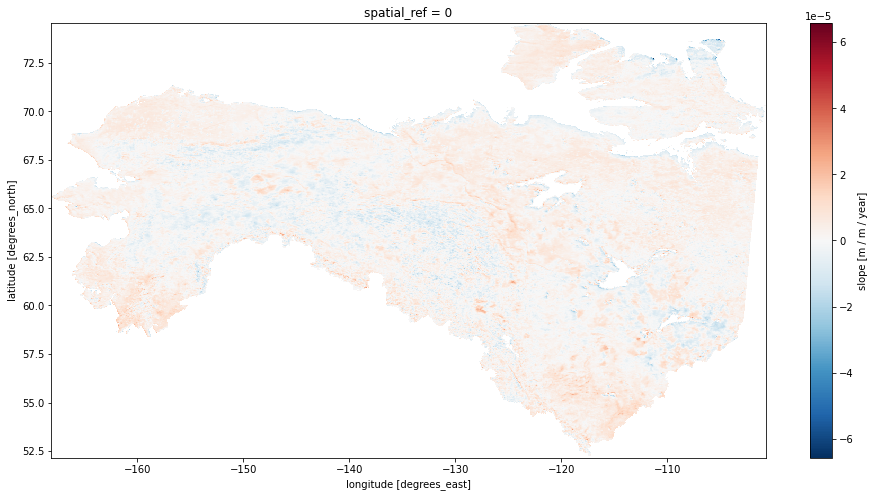

In [15]:
plt.figure(figsize=(16,8))
ndvi_growing_Lintrend["slope"].plot()
plt.savefig(data_dir+"/Figures/LAI_growing_trend.png")